# Tome cualquiera de estas propuestas o alguna suya y desarrolle

- Test con data augmentation y la LSTM
- Usar los tokenizadores usados en los transformers para ver como funcionan
- TSNE de embeddings y analizar si hay interpretación
- Probar con otras encimas o proteinas
- Usar los embeddings entrenados para analizar resultados de proteinas o encimas con menos data
- Entrenar una red neuronal con los features (fingerprints por ejemplo) y comparar los resultados con los embeddings


## Imports

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Embedding, Bidirectional, Activation, Input, Conv1D, MaxPool1D, Concatenate, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from datagen import smiles_dict, smiles_to_seq, DataGenerator

## Fingerprints

In [2]:
# Archivo csv generado a partir de las notebooks de los videos
df = pd.read_csv('data/acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

In [3]:
X = df.drop('pIC50', axis=1)

In [4]:
Y = df.pIC50

In [5]:
X.shape

(5103, 881)

In [6]:
Y.shape

(5103,)

In [7]:
# Filtrar columnas de X con mayor variabilidad
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [8]:
X.shape

(5103, 140)

In [9]:
# Train/ Test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Random Forest

In [10]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

RandomForestRegressor()

In [11]:
y_pred = model.predict(X_test)

In [12]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [13]:
r2

0.4268984658436281

D:\envs\DL\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(close=None, block=None)>

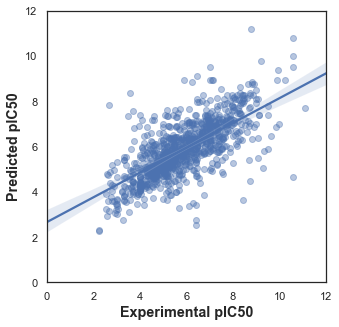

In [14]:
# Resultados
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(y_test, y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

### Entrenar una red neuronal con los features (fingerprints por ejemplo) y comparar los resultados con los embeddings

In [15]:
# Métrica

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [42]:
model = Sequential()
model.add(Dense(250, input_shape = (X_train.shape[1], ), name='C1', activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(50, name='C2', activation='relu'))
model.add(Dense(1, name='Salida'))

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Dense)                   (None, 250)               35250     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
C2 (Dense)                   (None, 50)                12550     
_________________________________________________________________
Salida (Dense)               (None, 1)                 51        
Total params: 47,851
Trainable params: 47,851
Non-trainable params: 0
_________________________________________________________________


In [63]:
def create_callbacks(model_type='mlp'):
    
    early_stop = EarlyStopping(
        monitor     = 'val_loss', 
        min_delta   = 0.01, 
        patience    = 50, 
        mode        = 'auto', 
        verbose     = 1
    )
    
    reduce_on_plateau = ReduceLROnPlateau(
        monitor  = 'val_loss',
        factor   = 0.2,
        patience = 10,
        verbose  = 1,
        mode     = 'min',
        min_delta  = 0.01,
        cooldown = 0,
        min_lr   = 1e-8
    )
    checkpoint = ModelCheckpoint(
        filepath        = 'models/best_model_'+ model_type + '_{epoch}.h5', 
        monitor         = 'val_R2', 
        verbose         = 1, 
        save_best_only  = True, 
        mode            = 'max', 
        period          = 1
    )

    return [early_stop, reduce_on_plateau, checkpoint]

In [45]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=[R2])

In [46]:
callbacks = create_callbacks()

In [47]:
history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/250
128/128 [==============================] - 1s 2ms/step - loss: 11.3505 - R2: -2.7497 - val_loss: 2.3337 - val_R2: 0.0975

Epoch 00001: val_R2 improved from -inf to 0.09749, saving model to models\best_model_mlp_1.h5
Epoch 2/250
128/128 [==============================] - 0s 1ms/step - loss: 2.4747 - R2: 0.0566 - val_loss: 2.0265 - val_R2: 0.2264

Epoch 00002: val_R2 improved from 0.09749 to 0.22640, saving model to models\best_model_mlp_2.h5
Epoch 3/250
128/128 [==============================] - 0s 1ms/step - loss: 2.1074 - R2: 0.1683 - val_loss: 1.8819 - val_R2: 0.2819

Epoch 00003: val_R2 improved from 0.22640 to 0.28187, saving model to models\best_model_mlp_3.h5
Epoch 4/250
128/128 [==============================] - 0s 1ms/step - loss: 2.3133 - R2: 0.1788 - val_loss: 1.8078 - val_R2: 0.3097

Epoch 00004: val_R2 improved from 0.28187 to 0.30970, saving model to models\best_model_mlp_4.h5
Epoch 5/250
128/128 [==============================] - 0s 1ms/step - loss: 1.9702 - R

In [49]:
y_pred = model.predict(X_test)

In [50]:
r2 = 1 - ((y_test.values - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [51]:
r2

0.41116386572577657

In [58]:
filename = 'models/fingerprints_140_MLP.h5'
model.save(filename)

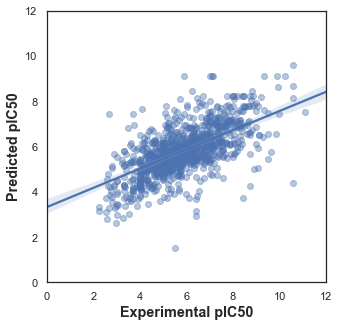

In [59]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show()

### Resultados : r2 con fingerprints es similar a Random Forest, e inferior a LSTM y CNN con embeddings (0.41 vs 0.60 vs 0.54)

## Test con data augmentation y la LSTM

In [ ]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20
X = df['canonical_smiles'].values
y = df['pIC50'].values
vocab_size = len(smiles_dict)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [66]:
# Implementar modelo completo
model = Sequential()

model.add(Embedding(input_dim = vocab_size + 1, output_dim = 64, input_length=max_sequence_len))
model.add(Bidirectional(layer=LSTM(units=100)))
model.add(Dense(units=50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(units=1))

In [93]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=[R2])

In [ ]:
callbacks = create_callbacks('lstm_aug')

In [94]:
history = model.fit(dgen_train, epochs=100, validation_data=dgen_test, callbacks=callbacks)

Epoch 1/100
32/32 [==============================] - 30s 872ms/step - loss: 1.8268 - R2: 0.3718 - val_loss: 1.9468 - val_R2: 0.3194

Epoch 00001: val_R2 did not improve from 0.48316
Epoch 2/100
32/32 [==============================] - 28s 869ms/step - loss: 1.6033 - R2: 0.4031 - val_loss: 1.7453 - val_R2: 0.3751

Epoch 00002: val_R2 did not improve from 0.48316
Epoch 3/100
32/32 [==============================] - 28s 883ms/step - loss: 1.7357 - R2: 0.4057 - val_loss: 1.6614 - val_R2: 0.4124

Epoch 00003: val_R2 did not improve from 0.48316
Epoch 4/100
32/32 [==============================] - 28s 888ms/step - loss: 1.5505 - R2: 0.4556 - val_loss: 2.2386 - val_R2: 0.1758

Epoch 00004: val_R2 did not improve from 0.48316
Epoch 5/100
32/32 [==============================] - 29s 906ms/step - loss: 1.6290 - R2: 0.4008 - val_loss: 2.8149 - val_R2: -0.0278

Epoch 00005: val_R2 did not improve from 0.48316
Epoch 6/100
32/32 [==============================] - 30s 923ms/step - loss: 1.6379 - R2: 

In [96]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

y_pred = model.predict(X_test_eval)

In [97]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [98]:
r2

0.5064727921911204

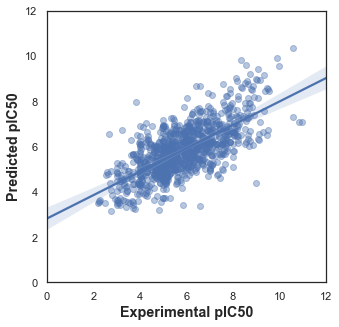

In [104]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show()

In [99]:
model.save('models/embed_64_bi_lstm_100_dense_50_bn_aug.h5')

### Resultados : r2 con LSTM y data augmentation no mejora mucho el r2. Seguramente con mas tiempo de entrenamiento alcance valores de r2 similares a sin data augmentation

## TSNE de embeddings

In [174]:
model_lstm = load_model('models/embed_64_bi_lstm_100_dense_50_bn.h5', custom_objects={'R2': R2})
d1 = {'c': 1, 'C': 2, '(': 3, ')': 4, '1': 5, 'O': 6, '2': 7, 'N': 8, '=': 9, '3': 10, '[': 11, ']': 12, '@': 13, 'n': 14, '4': 15,'H': 16, 
      '-': 17, '/': 18, 'l': 19, '.': 20, '+': 21, 'F': 22, '5': 23, 'o': 24, 'B': 25, 'r': 26, 'S': 27, '\\': 28, '#': 29, '6': 30, 's': 31, 
      'I': 32, 'e': 33, 'P': 34, '7': 35, '8': 36, 'i': 37, 'a': 38}

model_cnn = load_model('models/embed_128_text_cnn_aug_100x100_0.0001.h5', custom_objects={'R2': R2})
d2 = smiles_dict

models = [model_lstm, model_cnn]
dicts = [d1, d2]
titles = ['LSTM', 'CNN']

In [175]:
tsne = TSNE(2)

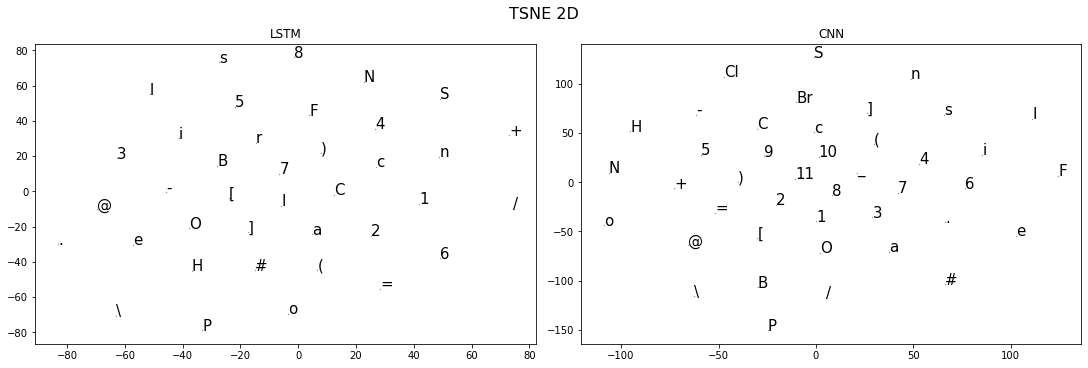

In [181]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5))
fig.suptitle('TSNE 2D', fontsize=16)
j = 0
for model, d, title in zip(models, dicts, titles):
    embedings = model.layers[j].get_weights()[0][1:]
    X_2 = tsne.fit_transform(embedings)
    axs[j].scatter(X_2[:, 0], X_2[:, 1], s=0.1)
    for i, token in enumerate(d):
        axs[j].text(X_2[i, 0], X_2[i, 1], token, fontsize=15)
    
    axs[j].set_title(title)
    j+=1

plt.show()

### Resultados : No parece haber clusters bien definidos en ninguno de los dos casos. En el modelo CNN parece que los numeros estan mas juntos y cerca del (0,0) asi como algunos caracteres no alfanumericos. En ambos casos C y c (Carbono?) estan juntos